In [65]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
plt.style.use('ggplot')

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM,Dense, Dropout




import requests
import json

In [66]:
#df = pd.read_csv(r'D:\screener_project\ai_bots\lstm_predictor\BTC-USD.csv')
#df.tail()


tickerHistoryResponse = requests.get("https://financialmodelingprep.com/api/v3/"+"historical-price-full/"+"AAPL"+"?apikey="+"56e431b750c849dd5d42c5c0443186fc")
dailyHistory=tickerHistoryResponse.json()['historical'][::-1]
df = pd.DataFrame(dailyHistory)
df.tail()



,date,open,high,low,close,adjClose,volume,unadjustedVolume,change,changePercent,vwap,label,changeOverTime
1253,2021-03-30,120.110001,120.400002,118.860001,119.900002,119.900002,85671900.0,85671900.0,-0.21,-0.175,119.72000,"March 30, 21",-0.00175
1254,2021-03-31,121.650002,123.519997,121.150002,122.150002,122.150002,118323800.0,118323800.0,0.50,0.411,122.27333,"March 31, 21",0.00411
1255,2021-04-01,123.660004,124.180000,122.489998,123.000000,123.000000,75089100.0,75089100.0,-0.66,-0.534,123.22333,"April 01, 21",-0.00534
1256,2021-04-05,123.870003,126.160004,123.070000,125.900002,125.900002,88395400.0,88395400.0,2.03,1.639,125.04334,"April 05, 21",0.01639
1257,2021-04-06,126.500000,127.129997,125.650002,126.209999,126.209999,80171253.0,80171253.0,-0.29,-0.229,126.33000,"April 06, 21",-0.00229


In [67]:
df = df.set_index("date")[['open']].tail(1000)
df = df.set_index(pd.to_datetime(df.index))

df.head()
print('done')

done


In [68]:
scaler = MinMaxScaler()
df = pd.DataFrame(scaler.fit_transform(df), columns =df.columns, index=df.index)
df.head()

,open
date,
2017-04-17,0.000600
2017-04-18,0.000439
2017-04-19,0.001524
2017-04-20,0.000000
2017-04-21,0.002816


done


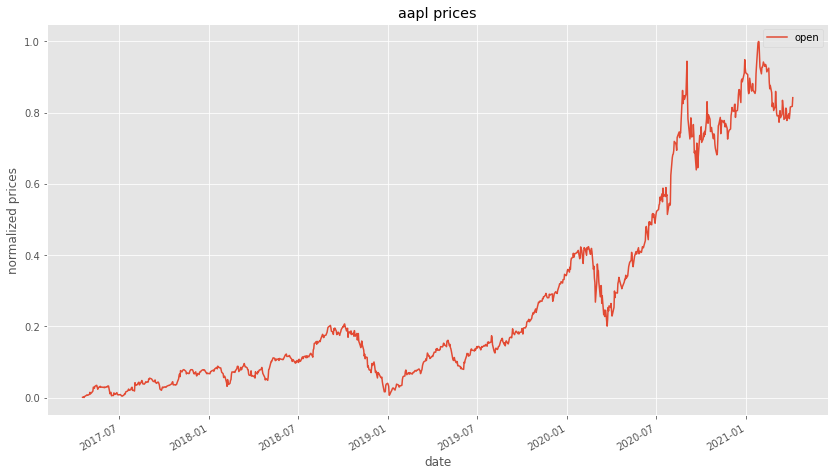

In [69]:
print('done')
df.plot(figsize=(14,8))
plt.title('aapl prices')
plt.ylabel('normalized prices')
plt.show()

In [70]:
def split_sequences(seq, n_steps_in, n_steps_out):
    X,y =[], []
    
    for i in range(len(seq)):
        end = i+n_steps_in
        out_end = end+ n_steps_out
        
        if out_end >len(seq):
            break
            
        seq_x, seq_y = seq[i:end], seq[end:out_end]
        
        X.append(seq_x)
        y.append(seq_y)
    
    return np.array(X), np.array(y)

In [71]:
def visualize_results(results):
    history = results.history
    plt.figure(figsize=(12,4))
    plt.plot(history['val_loss'])
    plt.plot(history['loss'])
    plt.legend(['val_loss','loss'])
    plt.title('Loss')
    plt.xlabel('epochs')
    plt.ylabel('loss')
    plt.show()
    
    plt.figure(figsize=(12,4))
    plt.plot(history['val_accuracy'])
    plt.plot(history['accuracy'])
    plt.legend(['val_accuracy','accuracy'])
    plt.title('Accuracy')
    plt.xlabel('epochs')
    plt.ylabel('accuracy')
    plt.show()

In [72]:
n_per_in = 30
n_per_out = 1

n_features = 1

X,y = split_sequences(list(df.open), n_per_in,n_per_out)

print(X.shape)

X = X.reshape(X.shape[0],X.shape[1],n_features)

print(X.shape)
print(y.shape)

(970, 30)
(970, 30, 1)
(970, 1)


In [73]:
model = Sequential()
model.add(LSTM(40, activation='softsign', return_sequences=True, input_shape=(n_per_in,n_features)))
model.add(LSTM(15, activation='softsign', return_sequences=True))
model.add(LSTM(15, activation='softsign', return_sequences=True))
model.add(LSTM(15, activation='softsign', return_sequences=True))
model.add(LSTM(15, activation='softsign', return_sequences=True))
model.add(LSTM(15, activation='softsign'))
model.add(Dense(n_per_out))

model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_24 (LSTM)               (None, 30, 40)            6720      
_________________________________________________________________
lstm_25 (LSTM)               (None, 30, 15)            3360      
_________________________________________________________________
lstm_26 (LSTM)               (None, 30, 15)            1860      
_________________________________________________________________
lstm_27 (LSTM)               (None, 30, 15)            1860      
_________________________________________________________________
lstm_28 (LSTM)               (None, 30, 15)            1860      
_________________________________________________________________
lstm_29 (LSTM)               (None, 15)                1860      
_________________________________________________________________
dense_4 (Dense)              (None, 1)                

In [74]:
model.compile(optimizer='adam',loss='mse', metrics=['accuracy'])

In [75]:
res = model.fit(X,y, epochs=120, batch_size=32, validation_split=0.1)

Epoch 1/120
28/28 [==============================] - 6s 43ms/step - loss: 0.0482 - accuracy: 0.0000e+00 - val_loss: 0.3117 - val_accuracy: 0.0000e+00
Epoch 2/120
28/28 [==============================] - 1s 23ms/step - loss: 0.0227 - accuracy: 0.0000e+00 - val_loss: 0.0499 - val_accuracy: 0.0103
Epoch 3/120
28/28 [==============================] - 1s 23ms/step - loss: 0.0038 - accuracy: 0.0000e+00 - val_loss: 0.0062 - val_accuracy: 0.0103
Epoch 4/120
28/28 [==============================] - 1s 23ms/step - loss: 0.0024 - accuracy: 0.0000e+00 - val_loss: 0.0067 - val_accuracy: 0.0103
Epoch 5/120
28/28 [==============================] - 1s 23ms/step - loss: 0.0023 - accuracy: 0.0000e+00 - val_loss: 0.0106 - val_accuracy: 0.0103
Epoch 6/120
28/28 [==============================] - 1s 23ms/step - loss: 0.0020 - accuracy: 0.0000e+00 - val_loss: 0.0065 - val_accuracy: 0.0103
Epoch 7/120
28/28 [==============================] - 1s 23ms/step - loss: 0.0021 - accuracy: 0.0000e+00 - val_loss: 0.00

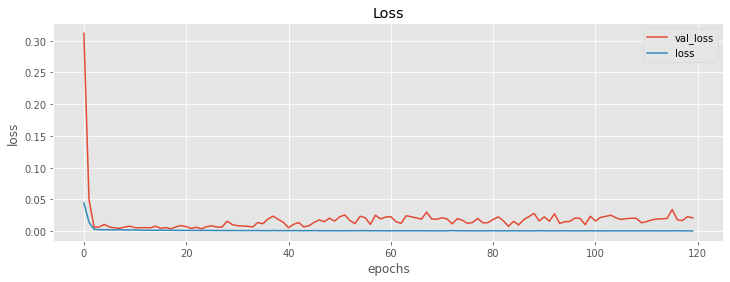

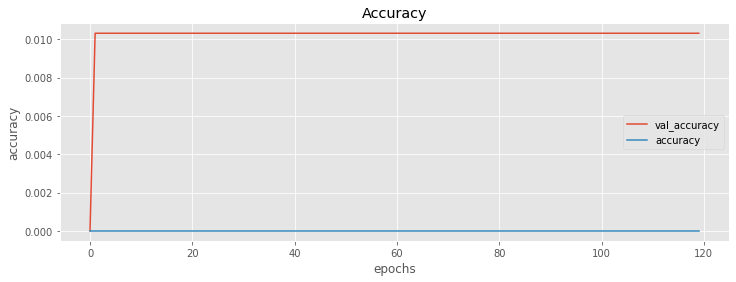

In [76]:
visualize_results(res)

predicted  [[114.71813783149577]]
actuals  [[126.49999999999999]]


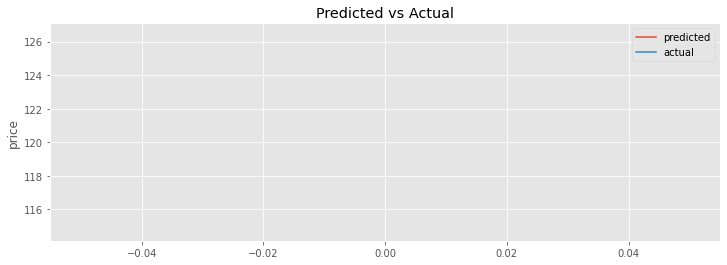

In [77]:
plt.figure(figsize=(12,4))

yhat = model.predict(X[-1].reshape(1,n_per_in,n_features)).tolist()[0]

yhat = scaler.inverse_transform(np.array(yhat).reshape(-1,1)).tolist()

actual = scaler.inverse_transform(y[-1].reshape(-1,1))

print("predicted ", yhat)
plt.plot(yhat, label='predicted')

print("actuals ", actual.tolist())
plt.plot(actual.tolist(), label='actual')

plt.title("Predicted vs Actual")
plt.ylabel('price')
plt.legend()
plt.show()

                  open
2021-04-06  114.663684


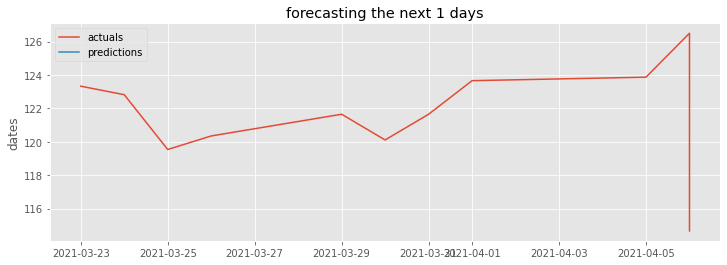

In [78]:
yhat = model.predict(np.array(df.tail(n_per_in)).reshape(1,n_per_in,n_features)).tolist()[0]
yhat = scaler.inverse_transform(np.array(yhat).reshape(-1,1)).tolist()

preds = pd.DataFrame(yhat, index=pd.date_range(start=df.index[-1], periods=len(yhat),freq="D"), columns=df.columns)

print(preds)

periods = 10

actual = pd.DataFrame(scaler.inverse_transform(df[['open']].tail(periods)), index = df.open.tail(periods).index, columns = df.columns).append(preds.head(1))

plt.figure(figsize=(12,4))
plt.plot(actual, label='actuals')
plt.plot(preds, label='predictions')
plt.ylabel("price")
plt.ylabel('dates')
plt.title(f'forecasting the next {len(yhat)} days')
plt.legend()
plt.show()